# Machine Learning (M606B) Final Project

Student Name: Seyyed Jalal Tabatabaee<br/>
Student ID: GH1033801<br/>
Github Link: https://github.com/shayantabatabaee/shark-attacks-classification <br/>
Dataset Link: https://www.kaggle.com/datasets/gauravkumar2525/shark-attacks/data

## Introduction

This Jupyter notebook is part of the final project for the machine learning course at Gisma University of Applied Sciences. It aims to apply traditional machine learning methods to the <b>Shark Attacks</b> dataset. The Global Shark Attacks Dataset provides a detailed record of human-shark interactions worldwide. It includes information like the date, location, type of attack, activity of the person, shark species involved, and whether the attack was fatal. As the author noted, this dataset is useful for researchers, marine biologists, conservationists, and enthusiasts who want to study shark behavior, understand attack patterns, and improve ocean safety.

In the first part of this notebook, I will install the required dependencies and load the data. Next, we will check how clean the dataset is and, if needed, I will apply a cleaning pipeline and best practices to prepare the dataset. In the last part, machine learning methods will be used on the dataset for a classification task, and the best model among them will be saved. Finally, the classification metrics and overall evaluation will be described in detail.

## Install Libraries

In [419]:
!pip install kagglehub
!pip install pandas
!pip install missingno
!pip install geopy
!pip install tqdm
!pip install feature_engine
!pip install matplotlib
!pip install numpy
!pip install scikit-learn
!pip install seaborn
!pip install imblearn

## Import Libraries

In [505]:
import kagglehub
import os
import pandas as pd
import time
from tqdm.notebook import tqdm
import missingno as msno
import re
import math
import sklearn
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut
from feature_engine.encoding import RareLabelEncoder
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import imblearn
from collections import Counter
import pickle

# Data Preprocessing

## Download Dataset

In [23]:
dataset_path = kagglehub.dataset_download("gauravkumar2525/shark-attacks")
print("Path to dataset files:", dataset_path)
print("Dataset Filename:", os.listdir(dataset_path)[0])

Path to dataset files: /Users/shayantabatabaee/.cache/kagglehub/datasets/gauravkumar2525/shark-attacks/versions/1
Dataset Filename: global_shark_attacks.csv


## Load Dataset

In [24]:
data = pd.read_csv(os.path.join(dataset_path, os.listdir(dataset_path)[0]))
print("Data loaded successfully!")
print(f"Dataset shape: {data.shape}")
data.head()

Data loaded successfully!
Dataset shape: (6890, 13)


,date,year,type,country,area,location,activity,name,sex,age,fatal_y_n,time,species
0,2023-05-13,2023.0,Unprovoked,AUSTRALIA,South Australia,Elliston,Surfing,Simon Baccanello,M,46,Y,10h10,White shark
1,2023-04-29,2023.0,Unprovoked,AUSTRALIA,Western Australia,"Yallingup, Busselton",Swimming,male,M,NaN,N,11h20,1m shark
2,2022-10-07,2022.0,Unprovoked,AUSTRALIA,Western Australia,Port Hedland,Spearfishing,Robbie Peck,M,38,N,11h30,Bull shark
3,2021-10-04,2021.0,Unprovoked,USA,Florida,"Fort Pierce State Park, St. Lucie County",Surfing,Truman Van Patrick,M,25.0,N,NaN,NaN
4,2021-10-03,2021.0,Unprovoked,USA,Florida,"Jensen Beach, Martin County",Swimming,male,M,NaN,N,12h00,NaN


## Clean Dataset

In this section, I will first check if there are any missing values. I will also look at the data type for each column. If the data type is numerical and there are no missing values, we’re ready to move forward, but later we’ll need to check the distribution of the data to see if there are too many zeros. If the data type is object and categorical, we’ll check each value in the column to ensure they make sense. The most helpful library for getting insights about all features at once is <i>missingno</i>. Let's first check our targets i.e. <i>fatal_y_n</i> column and remove if there is nonsense values. Next I will check the NaN and empty values for all features using this library.

In [30]:
data['fatal_y_n'].value_counts()

fatal_y_n
N          4804
Y          1447
UNKNOWN     631
F             3
y             1
Y x 2         1
n             1
2017.0        1
Nq            1
Name: count, dtype: int64

As we can see, there are 631 UNKNOWN values which we can remove the rows. Also for example there are 3 F and 1 y which we can combine with N and Y targets.

In [35]:
# Remove UNKNOWN rows
data = data[data['fatal_y_n'] != 'UNKNOWN']
# Replace other values
data['fatal_y_n'] = data['fatal_y_n'].replace({
    'F': 'N',
    'y': 'Y',
    'Y x 2': 'Y'
})
# Keep only valid values (N and Y)
data = data[data['fatal_y_n'].isin(['N', 'Y'])]

In [36]:
data['fatal_y_n'].value_counts()

fatal_y_n
N    4807
Y    1449
Name: count, dtype: int64

Now our target column is clean, Let's check the other columns as well.

<Axes: >

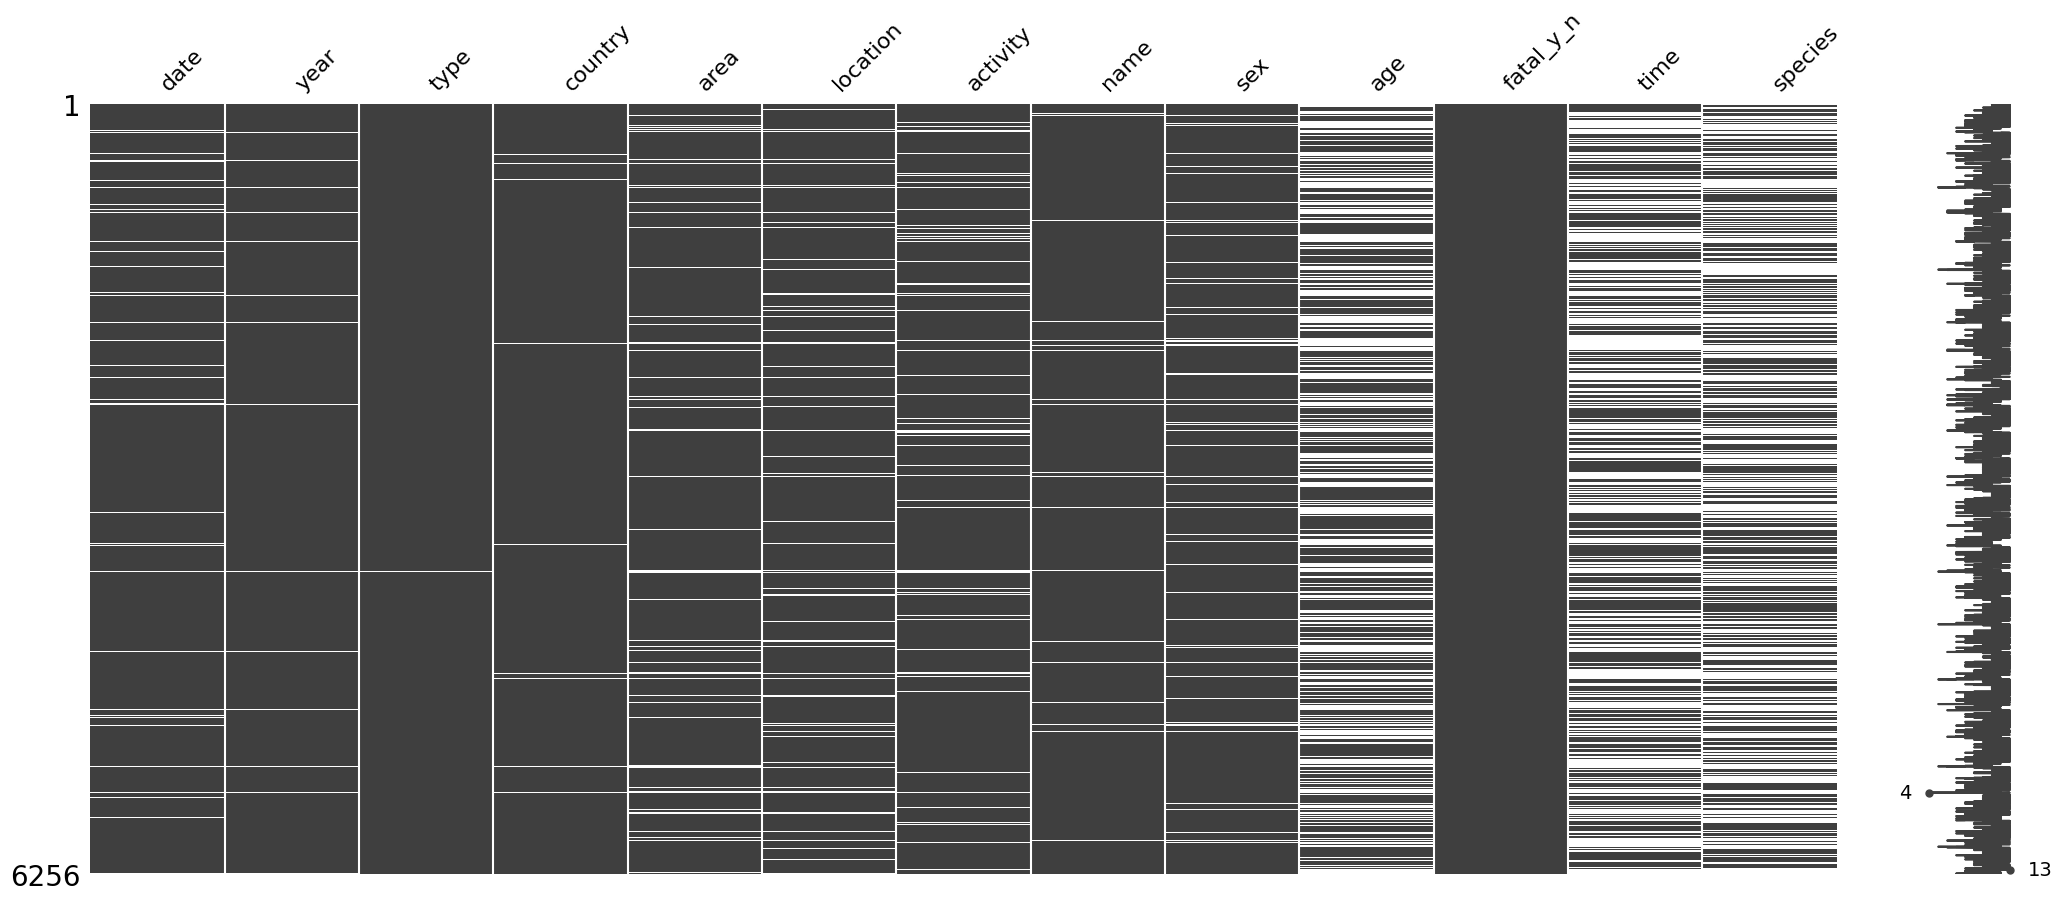

In [37]:
%matplotlib inline
msno.matrix(data)

As we can see in the images above, the white sections show that there are many null values in our dataset. For example, these columns have fewer null values: ['date', 'year', 'type', 'country', 'name', 'fatal_y_n']. But on the other hand, the ['age', 'time', 'species'] columns have a lot of null values. Let's check the datatypes of each column.

In [28]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6890 entries, 0 to 6889
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date       6587 non-null   object 
 1   year       6758 non-null   float64
 2   type       6871 non-null   object 
 3   country    6839 non-null   object 
 4   area       6409 non-null   object 
 5   location   6325 non-null   object 
 6   activity   6304 non-null   object 
 7   name       6670 non-null   object 
 8   sex        6318 non-null   object 
 9   age        3903 non-null   object 
 10  fatal_y_n  6890 non-null   object 
 11  time       3372 non-null   object 
 12  species    3772 non-null   object 
dtypes: float64(1), object(12)
memory usage: 699.9+ KB
None


The only column that is numerical is <i>year</i>, so we can use some feature imputation techniques for this column like replace null values with mean, median or a fixed value. For other columns let's check the values to get better insights.

In [39]:
for column in data.columns:
  if data[column].dtype == type(object):
    print(f"{column}: {data[column].unique()}")

date: ['2023-05-13' '2023-04-29' '2022-10-07' ... '1828-01-01' '1792-09-12'
 '1703-03-26']
type: ['Unprovoked' 'Provoked' 'Invalid' 'Watercraft' 'Sea Disaster'
 'Questionable' nan 'Boat' 'Unverified' '?' 'Under investigation']
country: ['AUSTRALIA' 'USA' 'JAMAICA' 'NEW ZEALAND' 'PAPUA NEW GUINEA'
 'FRENCH POLYNESIA' 'CHINA' 'SOUTH AFRICA' 'BAHAMAS' 'NEW CALEDONIA'
 'REUNION' 'PALESTINIAN TERRITORIES' 'BELIZE' 'PHILIPPINES' 'MOZAMBIQUE'
 'KENYA' 'BRAZIL' 'FIJI' 'TANZANIA' 'ENGLAND' 'THAILAND' 'SOUTH KOREA'
 'MAURITIUS' 'ITALY' 'MEXICO' 'MARSHALL ISLANDS' 'SPAIN' 'TAIWAN' 'TURKEY'
 'SENEGAL' 'AMERICAN SAMOA' 'PACIFIC OCEAN' 'INDIAN OCEAN' 'NEW GUINEA'
 'SOLOMON ISLANDS' 'GREECE' 'COSTA RICA' 'INDONESIA' 'CUBA' 'GEORGIA'
 'SIERRA LEONE' 'Coast of AFRICA' 'INDIA' 'TOBAGO' 'EGYPT' 'SAMOA'
 'DOMINICAN REPUBLIC' 'MADAGASCAR' 'MALAYSIA' 'GULF OF ADEN' 'SOMALIA'
 'CHILE' nan 'SINGAPORE' 'BRITISH WEST INDIES' 'NORTH ATLANTIC OCEAN'
 'SRI LANKA' 'OKINAWA' 'SOUTH PACIFIC OCEAN' 'SOUTH ATLANTIC OCE

As we can see in our features, the <i>date</i> and <i>year</i> columns represent the same information and are duplicates, so for the first step, we remove the <i>date</i> column and replace null values in the <i>year</i> column with the average of the years. This dataset is messy, and we need to take a specific action for each column.

In [43]:
if 'date' in data.columns:
    data = data.drop(columns=['date'])
data['year'] = data['year'].fillna(round(data['year'].mean()))

Now for the next step let's focus on <i>type</i> column.

In [45]:
data['type'].value_counts()

type
Unprovoked             4991
Provoked                623
Watercraft              340
Sea Disaster            237
Invalid                  25
Questionable             16
Boat                      7
Unverified                1
?                         1
Under investigation       1
Name: count, dtype: int64

In [51]:
data['type'] = data['type'].replace('?', None)
data = data.dropna(subset=['type'])

Now, for the <i>country, area, location</i> columns, we first remove the location column because, after checking its values, it seems mostly nonsensical and useless. Next, we remove any row where both country and area are None at the same time. Later, I will convert the combination of area and country into latitude and longitude since that will give us more useful information.

In [60]:
if 'location' in data.columns:
    data = data.drop(columns=['location'])
data = data.dropna(subset=['area', 'country'], how='all')

In [81]:
geolocator = Nominatim(user_agent="geo_converter")
def get_latitude_longitude(area, country):
    try:
        location = geolocator.geocode(f"{area}, {country}")
        time.sleep(0.75)
        if location:
            return pd.Series([location.latitude, location.longitude])
    except GeocoderTimedOut:
        return pd.Series([None, None])
    return pd.Series([None, None])

tqdm.pandas()
data[['latitude', 'longitude']] = data.progress_apply(lambda x: get_latitude_longitude(x['area'], x['country']), axis=1)

  0%|          | 0/6212 [00:00<?, ?it/s]

As we can see, the above method takes almost two hours to complete. In order not to wait, I commited the outcome and comitted alongside the jupyter notebook into Github repository. The dataframe can be loaded into data using the following command.

In [460]:
data = pd.read_csv('shark_attacks_lat_long.csv',index_col=0)

In [462]:
if 'area' in data.columns:
     data = data.drop(columns=['area'])
if 'country' in data.columns:
     data = data.drop(columns=['country'])

Now it is time to take a look at <i>latitude</i> and <i>longitude</i> columns, since some of the might be null due to not finding location using geopy API. So we remove rows which there are not any coordinate for them.

In [463]:
data = data.dropna(subset=['latitude', 'longitude'], how='all')

For <i>activity</i> column first we will check the distribution over different values, and we will notice the are some rare values. we will use RareLabelEncoder to convert infrequent values into 'Other'. 

In [464]:
data['activity'].value_counts()

activity
Surfing                                                      1053
Swimming                                                      844
Fishing                                                       439
Spearfishing                                                  320
Wading                                                        157
                                                             ... 
Surfing (or sailboarding)                                       1
Surfing & dangling foot in water amid baitfish                  1
Inspecting teeth of supposedly dead (hooked & shot) shark       1
Free diving, collecting shells                                  1
Crew swimming alongside their anchored ship                     1
Name: count, Length: 1241, dtype: int64

In [465]:
data['activity'] = data['activity'].fillna('Other')
rare_encoder = RareLabelEncoder(n_categories=1, max_n_categories=50, replace_with='Other', tol=10/data.shape[0])
data['activity'] = rare_encoder.fit_transform(data[['activity']])

For the next step the <i>name</i> column does not have information, because it is the name of person, so we can remove the entire column.

In [466]:
data = data.drop(columns=['name'])

Now, we check the <i>sex</i> column. We remove the columns which do not make sense and only keep 'M' and 'F'.

In [467]:
data['sex'].value_counts()

sex
M        4678
F         655
N           1
.           1
M x 2       1
lli         1
Name: count, dtype: int64

In [468]:
data = data[data['sex'].isin(['M', 'F'])]

For time column, when we look into values, we can see that there are different times, but most of them are in 'hhhmm' format. I decided to apply regex on the time column and change it to categorical variables with these values: ['Morning', 'Noon', 'Evening', 'Night'] and change the rest of the to 'Other'.

In [469]:
def categorize_time(value):
    match = re.match(r'(\d{1,2})h(\d{2})?', str(value))
    if match:
        hour = int(match.group(1))
        if 5 <= hour < 12:
            return "Morning"
        elif 12 <= hour < 17:
            return "Noon"
        elif 17 <= hour < 21:
            return "Evening"
        else:
            return "Night"
    else:
        return "Other" 
data['time'] = data['time'].apply(categorize_time)

For the <i>species</i> column again we will use RareLabelEncoder to encode infrequent values into 'Other'

In [470]:
data['species'].value_counts()

species
White shark                       149
Tiger shark                        74
Bull shark                         62
4' shark                           42
6' shark                           42
                                 ... 
1.5 m [5'] hammerhead shark         1
Sevengill shark, 2.4 m              1
White shark, 5 m                    1
1.8 m [6'] grey reef shark          1
Said to be a 7.6 m [25'] shark      1
Name: count, Length: 1328, dtype: int64

In [471]:
data['species'] = data['species'].fillna('Other')
rare_encoder = RareLabelEncoder(n_categories=1, max_n_categories=50, replace_with='Other', tol=25/data.shape[0])
data['species'] = rare_encoder.fit_transform(data[['species']])

In [472]:
data['species'].value_counts()

species
Other               4771
White shark          149
Tiger shark           74
Bull shark            62
6' shark              42
4' shark              42
1.8 m [6'] shark      34
1.5 m [5'] shark      29
3' shark              27
Wobbegong shark       26
4' to 5' shark        26
1.2 m [4'] shark      26
5' shark              25
Name: count, dtype: int64

For the last feature age, since originally this column should be of type int, but it is object and there are lots of null values, I decided to classify ages that have int type and others that is nonsense to 'Others'.

In [473]:
def classify_age(age):
    if pd.isna(age):
        return 'Others'
    elif age <= 12:
        return 'Child'
    elif age <= 19:
        return 'Teenager'
    elif age <= 35:
        return 'Young Adult'
    elif age <= 55:
        return 'Middle-aged Adult'
    else:
        return 'Senior'
data['age'] = pd.to_numeric(data['age'], errors='coerce')
data['age'] = data['age'].apply(classify_age)

Now that we cleaned all of our features, it is time to again check the <i>missingno</i> plot, and save our cleaned dataframe.

<Axes: >

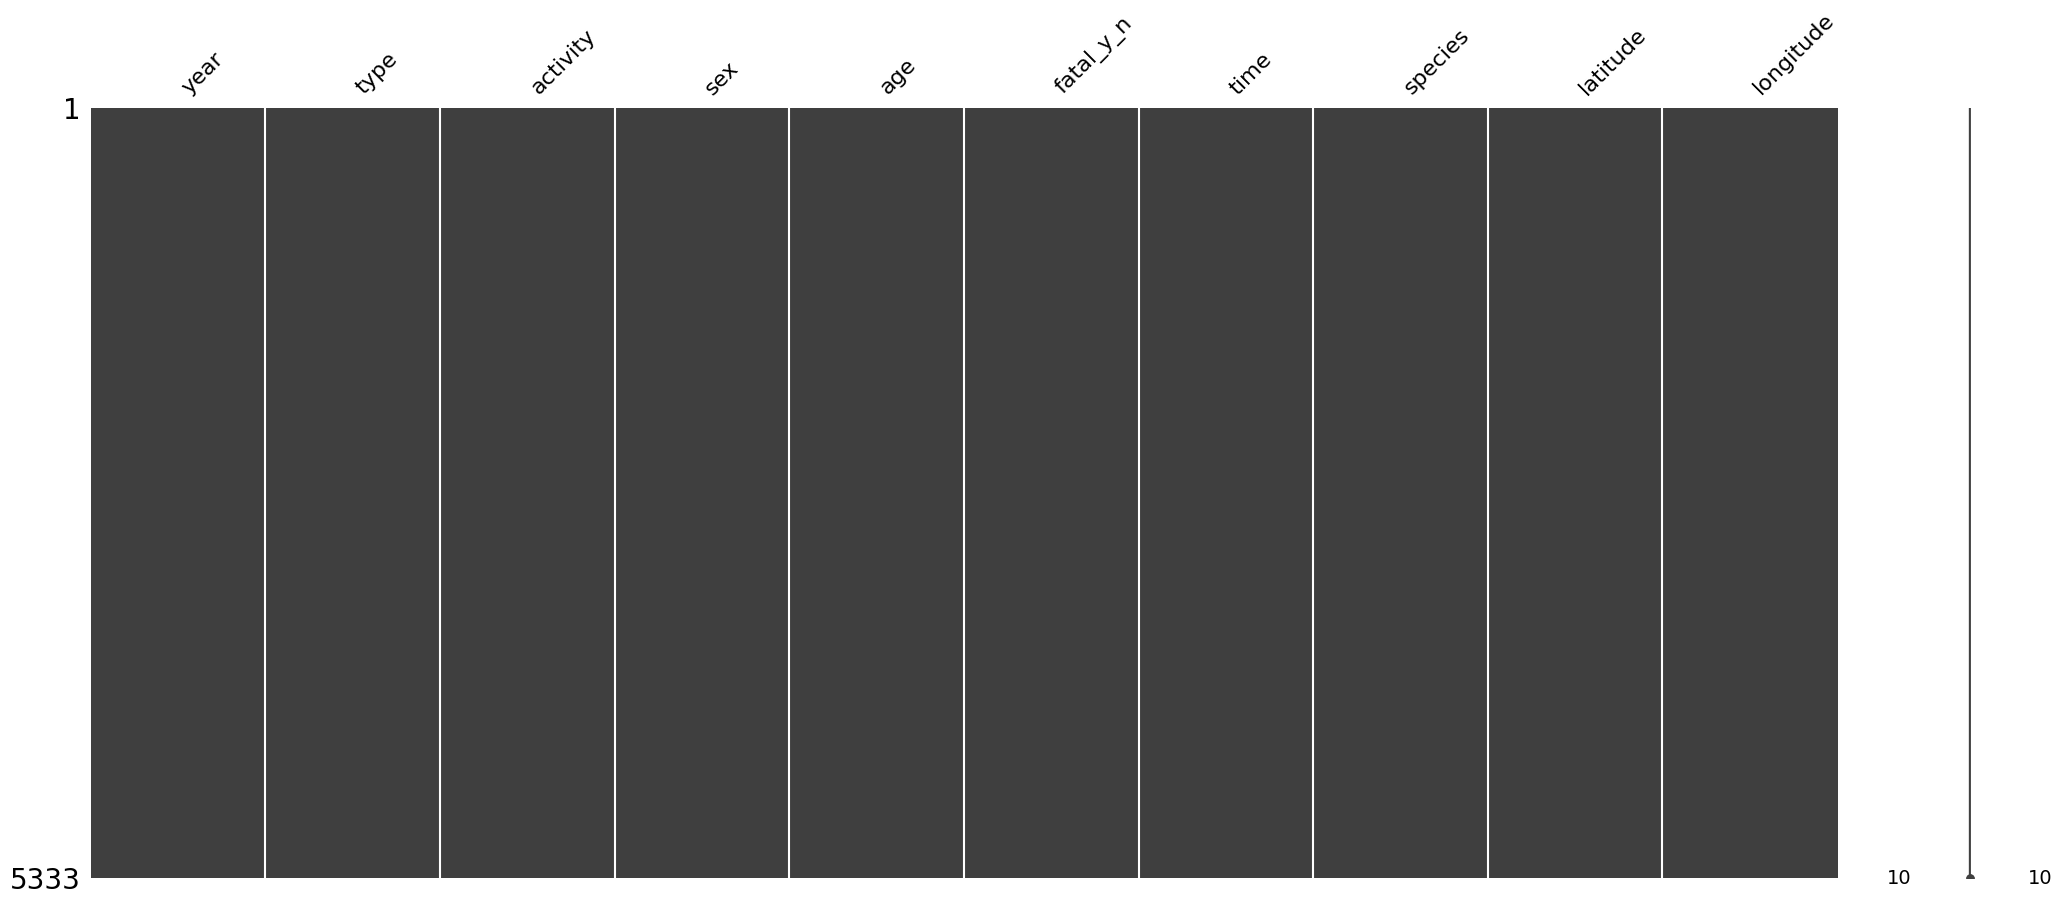

In [474]:
%matplotlib inline
msno.matrix(data)

As the above image shows us, now we have clean and none null values in our features. The original length of our data was 6890 and after cleaning is 5333 so we had to ignore 1557 rows.

In [148]:
data.to_csv('shark_attacks_clean.csv')

# Data Visualization

Now that we have our cleaned data, we will check the distribution of each feature to get more insight about the data. This task called EDA (exploratory data analysis).

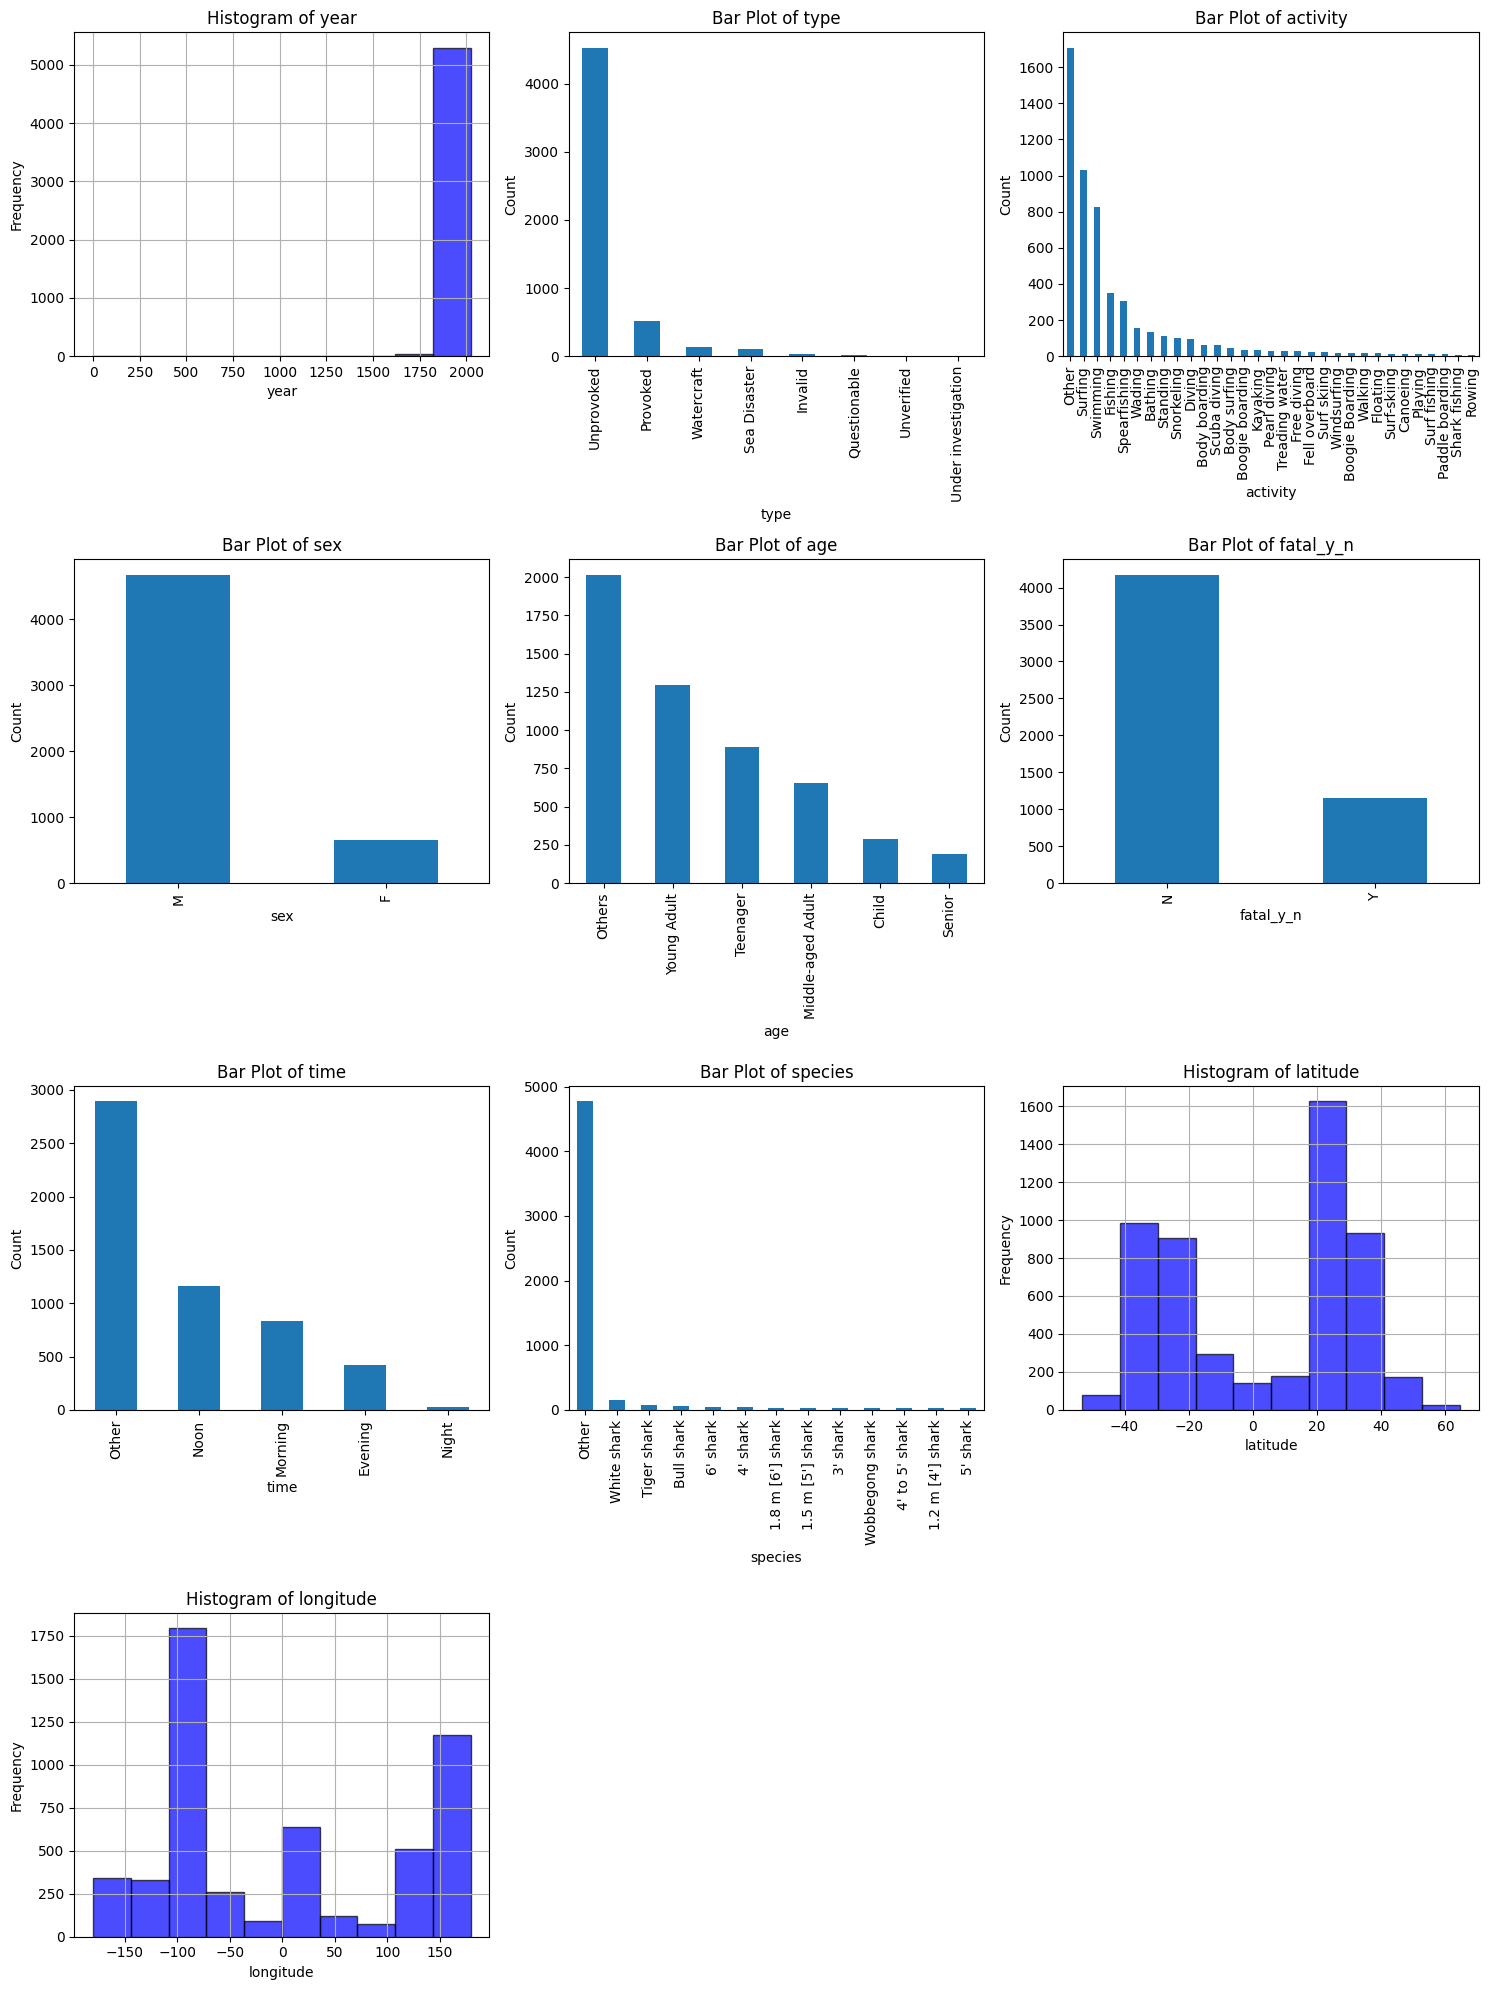

In [475]:
# Plot Each Feature and Target Into One Figure
num_cols = 3
num_features = len(data.columns)
num_rows = math.ceil(num_features / num_cols)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
axes = axes.flatten()

for i, column in enumerate(data.columns):
    ax = axes[i]
    if data[column].dtype == object:
        data[column].value_counts().plot(kind='bar', ax=ax, title=f"Bar Plot of {column}")
        ax.set_ylabel("Count")
    elif data[column].dtype in ['int64', 'float64']:
        data[column].hist(bins=10, alpha=0.7, color='blue', edgecolor='black', ax=ax)
        ax.set_title(f"Histogram of {column}")
        ax.set_xlabel(column)
        ax.set_ylabel("Frequency")

for j in range(len(data.columns), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# Feature Engineering

In this part, the main focus is on transforming and reformatting features into a format that machine learning algorithms can read. For example, with the year feature, we can change the <i>year</i> column to <i>years_ago</i> by subtracting the current year from the year. The other features that are categorical should be encoded, like with one-hot encoding. For latitude and longitude, most machine learning models use Euclidean distance to calculate the distance between two points, which doesn’t make sense for latitude and longitude since the Earth is spherical. To use latitude and longitude, we convert the values into Cartesian coordinates—x, y, z—in 3D space.

In [476]:
data['year'] = 2025 - data['year']

In [477]:
def latlon_to_cartesian(lat, lon):
    lat, lon = np.radians(lat), np.radians(lon)
    x = np.cos(lat) * np.cos(lon)
    y = np.cos(lat) * np.sin(lon)
    z = np.sin(lat)
    return x, y, z
data[['x', 'y', 'z']] = data.apply(lambda row: latlon_to_cartesian(row['latitude'], row['longitude']), axis=1, result_type='expand')
data = data.drop(columns = ['latitude', 'longitude'])

In [478]:
data.reset_index(drop=True, inplace=True)

In [479]:
one_hot_encoder = sklearn.preprocessing.OneHotEncoder(sparse_output=False)
one_hot_categorical_cols = ['type', 'activity', 'sex', 'age', 'time', 'species']
other_columns = ['x','y','z','year','fatal_y_n']
one_hot_encoded_features = one_hot_encoder.fit_transform(data[one_hot_categorical_cols])
data_encoded = pd.concat([pd.DataFrame(one_hot_encoded_features, columns=one_hot_encoder.get_feature_names_out(one_hot_categorical_cols)),
                          data[other_columns]]
                        , axis=1)

## Outlier Detection

There are different techniques in machine learning to detect outliers, and a popular one is IQR. In our data, when we look at the year column, we see some entries that are as old as 300 years ago. It’s clear these are outliers since there wouldn’t be historical data for shark attacks from that long ago. So, we will remove this data from our dataset.

In [480]:
count = (data_encoded['year'] > 300).sum()
print(count)

10


In [481]:
data_encoded = data_encoded[data_encoded['year'] <= 300]
data_encoded.reset_index(drop=True, inplace=True)
data_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5323 entries, 0 to 5322
Data columns (total 70 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   type_Invalid              5323 non-null   float64
 1   type_Provoked             5323 non-null   float64
 2   type_Questionable         5323 non-null   float64
 3   type_Sea Disaster         5323 non-null   float64
 4   type_Under investigation  5323 non-null   float64
 5   type_Unprovoked           5323 non-null   float64
 6   type_Unverified           5323 non-null   float64
 7   type_Watercraft           5323 non-null   float64
 8   activity_Bathing          5323 non-null   float64
 9   activity_Body boarding    5323 non-null   float64
 10  activity_Body surfing     5323 non-null   float64
 11  activity_Boogie Boarding  5323 non-null   float64
 12  activity_Boogie boarding  5323 non-null   float64
 13  activity_Canoeing         5323 non-null   float64
 14  activity

<Axes: >

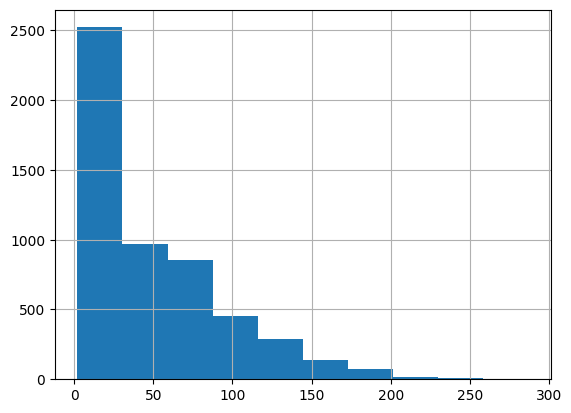

In [482]:
data_encoded['year'].hist()

## Correlation Matrix

<Axes: >

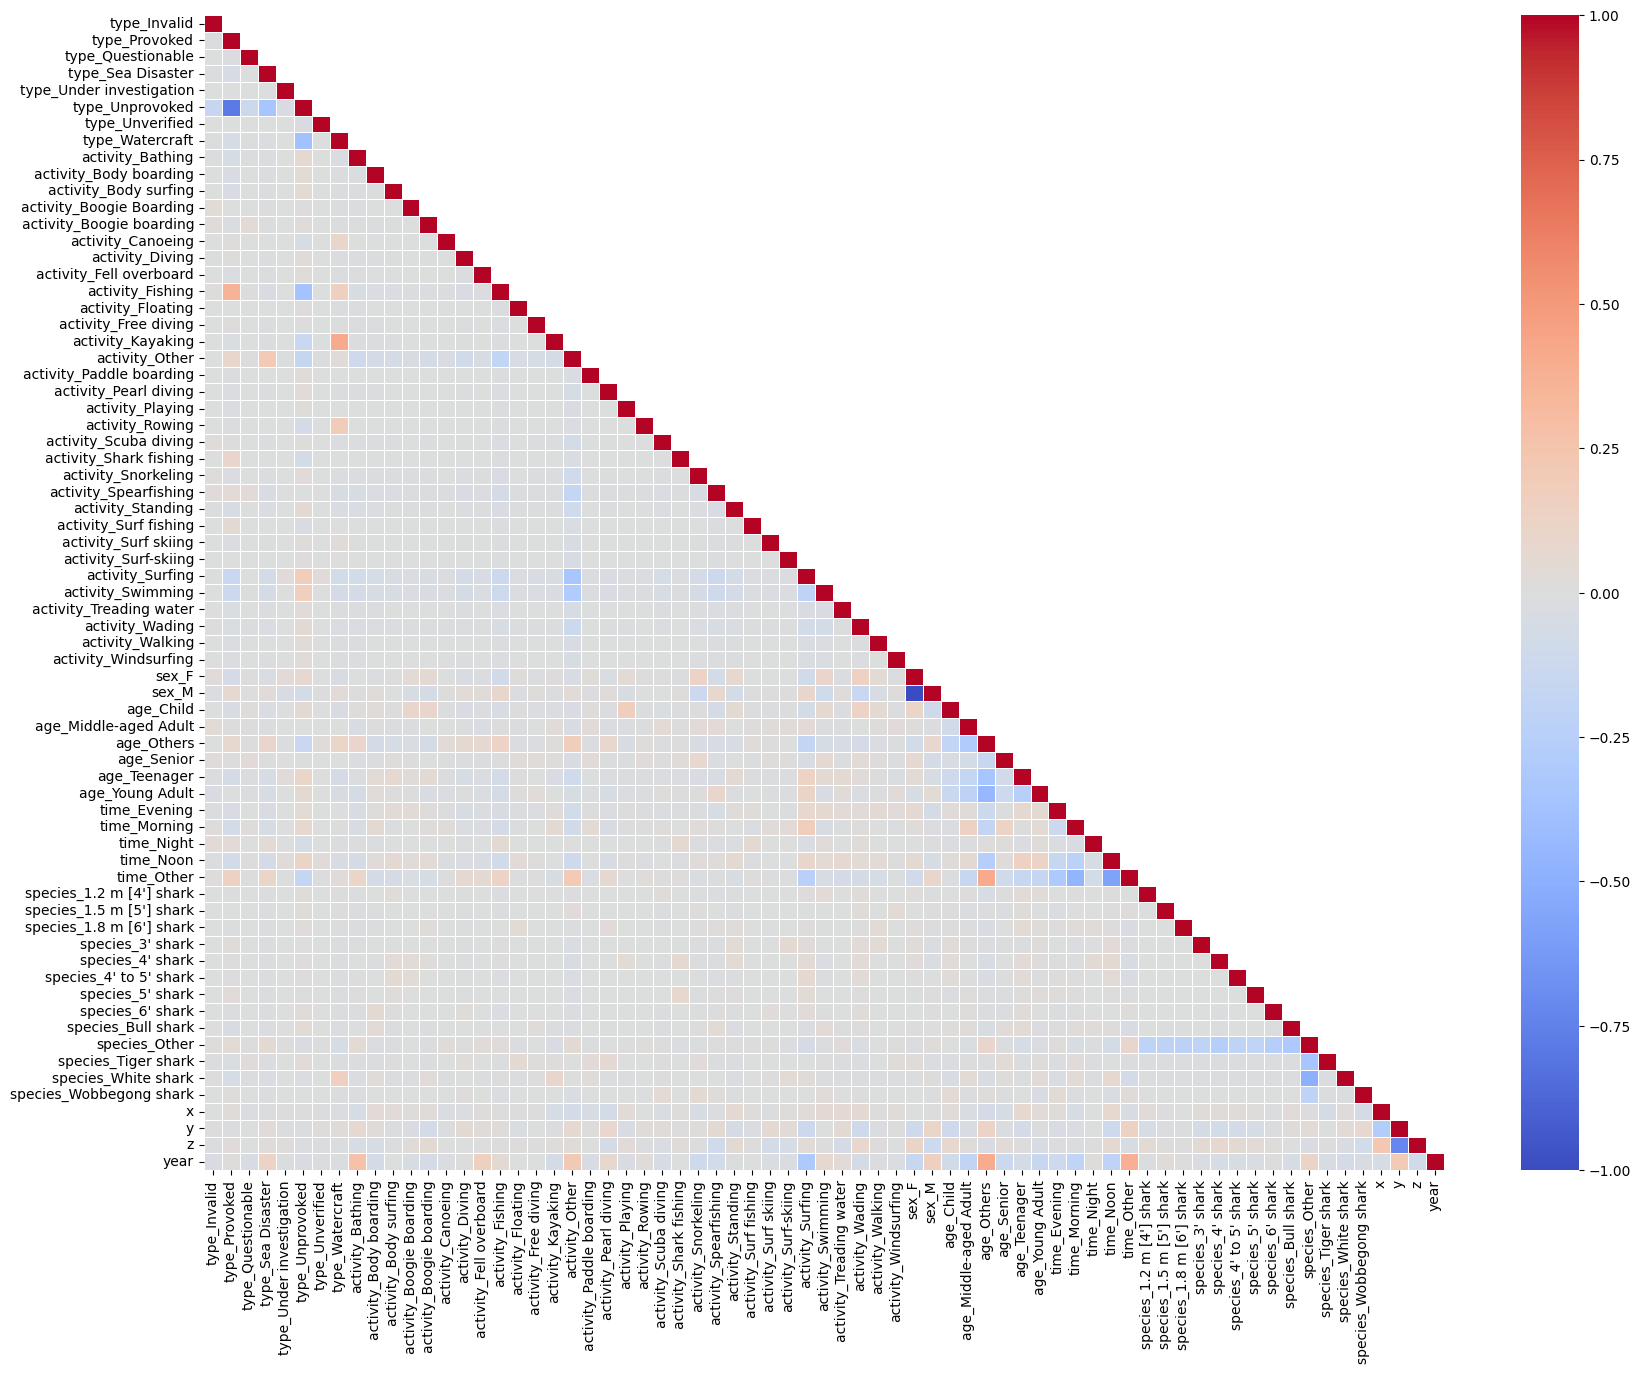

In [483]:
correlation_matrix = data_encoded.drop(columns=['fatal_y_n']).corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool), k=1)
fig, ax = plt.subplots(figsize=(20, 15))
sns.heatmap(correlation_matrix, mask=mask, cmap='coolwarm', annot=False, fmt=".2f", linewidths=0.5)

As we can see in the correlation matrix, there is no strong positive or negative correlation between features. So, we can now conclude that the features are not strongly dependent on each other.

# Model Training

## Split Data

In [484]:
data_encoded['fatal_y_n'] = data_encoded['fatal_y_n'].map({'Y': 1, 'N': 0})

In [541]:
data_train, data_temp = sklearn.model_selection.train_test_split(data_encoded, test_size=0.25, random_state=42)
data_validation, data_test = sklearn.model_selection.train_test_split(data_temp, test_size=0.50, random_state=42)
print(f"Train shape: {data_train.shape}")
print(f"Validation shape: {data_validation.shape}")
print(f"Test shape: {data_test.shape}")

Train shape: (3992, 70)
Validation shape: (665, 70)
Test shape: (666, 70)


In [542]:
X_train = data_train.drop(columns=['fatal_y_n'])
y_train = data_train['fatal_y_n']

X_validation = data_validation.drop(columns=['fatal_y_n'])
y_validation = data_validation['fatal_y_n']

X_test = data_test.drop(columns=['fatal_y_n'])
y_test = data_test['fatal_y_n']

## Balancing Data

In [543]:
smote = imblearn.over_sampling.SMOTE(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("Before SMOTE:", Counter(y_train))
print("After SMOTE:", Counter(y_train_resampled))

X_train = X_train_resampled
y_train = y_train_resampled

Before SMOTE: Counter({0: 3116, 1: 876})
After SMOTE: Counter({0: 3116, 1: 3116})


## Logistic Regression

In [544]:
logistic = sklearn.linear_model.LogisticRegression(class_weight='balanced', max_iter=2000, random_state=42)
logistic.fit(X_train, y_train)
y_pred_logistic_regression = logistic.predict(X_validation)

report = sklearn.metrics.classification_report(y_validation, y_pred_logistic_regression)

print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.76      0.82       521
           1       0.45      0.71      0.55       144

    accuracy                           0.75       665
   macro avg       0.68      0.73      0.69       665
weighted avg       0.81      0.75      0.76       665



## Naive Baye's

In [545]:
gnb = sklearn.naive_bayes.GaussianNB()
gnb.fit(X_train, y_train)
y_pred_naive_bayes = gnb.predict(X_validation)

report = sklearn.metrics.classification_report(y_validation, y_pred_naive_bayes)

print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.17      0.28       521
           1       0.24      0.93      0.38       144

    accuracy                           0.33       665
   macro avg       0.57      0.55      0.33       665
weighted avg       0.75      0.33      0.30       665



## SVM

In [546]:
svm = sklearn.svm.SVC(C=1.0, class_weight='balanced')
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_validation)

report = sklearn.metrics.classification_report(y_validation, y_pred_svm)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.68      0.77       521
           1       0.39      0.74      0.51       144

    accuracy                           0.69       665
   macro avg       0.64      0.71      0.64       665
weighted avg       0.79      0.69      0.72       665



## KNN

In [547]:
different_ks = [1, 3, 5, 10, 15, 30, 50, 100]     # K=10 would be optimal value

for k in different_ks:
  knn = sklearn.neighbors.KNeighborsClassifier(n_neighbors=k)
  knn.fit(X_train, y_train)
  y_pred_knn = knn.predict(X_validation)

  report = sklearn.metrics.classification_report(y_validation, y_pred_knn)
  print(f"Classification Report for k={k}:\n", report)

Classification Report for k=1:
               precision    recall  f1-score   support

           0       0.86      0.78      0.82       521
           1       0.41      0.55      0.47       144

    accuracy                           0.73       665
   macro avg       0.63      0.66      0.64       665
weighted avg       0.76      0.73      0.74       665

Classification Report for k=3:
               precision    recall  f1-score   support

           0       0.89      0.69      0.78       521
           1       0.39      0.69      0.50       144

    accuracy                           0.69       665
   macro avg       0.64      0.69      0.64       665
weighted avg       0.78      0.69      0.72       665

Classification Report for k=5:
               precision    recall  f1-score   support

           0       0.90      0.64      0.75       521
           1       0.37      0.75      0.49       144

    accuracy                           0.66       665
   macro avg       0.63      0.7

## Decision Tree

In [548]:
decision_tree = sklearn.tree.DecisionTreeClassifier()
decision_tree = decision_tree.fit(X_train,y_train)
y_pred_decision_tree = decision_tree.predict(X_validation)

report = sklearn.metrics.classification_report(y_validation, y_pred_decision_tree)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.88      0.87       521
           1       0.53      0.49      0.51       144

    accuracy                           0.79       665
   macro avg       0.69      0.68      0.69       665
weighted avg       0.79      0.79      0.79       665



## Bagging (Random Forest)

In [549]:
random_forest = sklearn.ensemble.RandomForestClassifier(n_estimators=30, random_state=42)
random_forest.fit(X_train, y_train)
y_pred_random_forest = random_forest.predict(X_validation)

report = sklearn.metrics.classification_report(y_validation, y_pred_random_forest)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.91      0.89       521
           1       0.60      0.47      0.53       144

    accuracy                           0.82       665
   macro avg       0.73      0.69      0.71       665
weighted avg       0.81      0.82      0.81       665



## Boosting

In [550]:
gradient_boosting = sklearn.ensemble.GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
gradient_boosting.fit(X_train, y_train)
y_pred_boosting = gradient_boosting.predict(X_validation)

report = sklearn.metrics.classification_report(y_validation, y_pred_boosting)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.88      0.88       521
           1       0.56      0.58      0.57       144

    accuracy                           0.81       665
   macro avg       0.72      0.73      0.73       665
weighted avg       0.81      0.81      0.81       665



After checking the output of different models, the metric I chose for my algorithm is the 'weighted avg' and 'macro avg' of the 'f1-score'. So let's combine both training and validation data and train the best model.

## Final Model

In [554]:
final_X_train = pd.concat([X_train.reset_index(drop=True), X_validation.reset_index(drop=True)], axis=0, ignore_index=True)
final_y_train = pd.concat([y_train.reset_index(drop=True), y_validation.reset_index(drop=True)], axis=0, ignore_index=True)
print(f"Final X Train shape: {final_X_train.shape}")
print(f"Final y Train shape: {final_y_train.shape}")

Final X Train shape: (6897, 69)
Final y Train shape: (6897,)


In [555]:
gradient_boosting = sklearn.ensemble.GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
gradient_boosting.fit(final_X_train, final_y_train)
y_pred_boosting = gradient_boosting.predict(X_test)

report = sklearn.metrics.classification_report(y_test, y_pred_boosting)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.89      0.89       534
           1       0.56      0.59      0.58       132

    accuracy                           0.83       666
   macro avg       0.73      0.74      0.73       666
weighted avg       0.83      0.83      0.83       666



In [556]:
with open('gradient_boosting_model.pkl', 'wb') as f:
    pickle.dump(gradient_boosting, f)

# Result

To have a better understanding Let’s take a look at the confusion matrix.

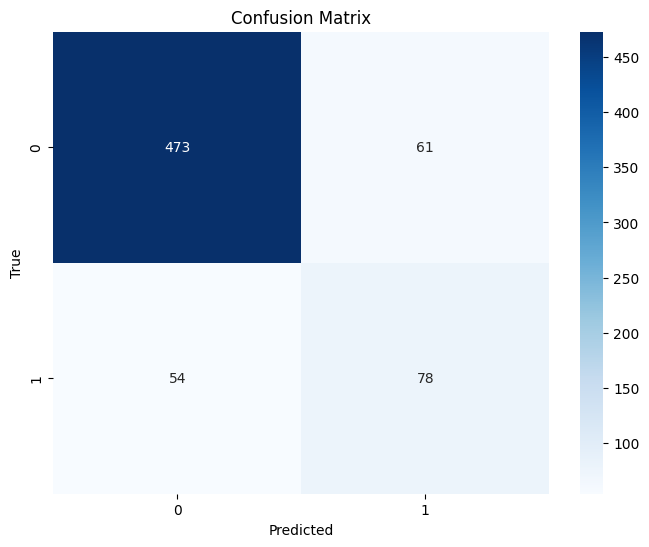

In [557]:
cm = sklearn.metrics.confusion_matrix(y_test, y_pred_boosting)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=gradient_boosting.classes_, yticklabels=gradient_boosting.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Here is the full detail of above image:

TP=78, TN=473, FP=61, FN=54 

From these values, along with the precision and recall for different labels, we can see that the model classifies zero labels better than one labels. The most likely reason is that we have an imbalanced dataset. Even though we tried to balance it, the method used synthesized data, which wasn’t very effective. We might need more real data for this topic. Also, when we look at the features and their distributions for <i>species</i>, <i>age</i>, and <i>type</i>, the most common value is 'Others'. So, these columns don’t give us enough useful information. We couldn’t ignore these columns because, for example, the age of the person attacked is important—adults often survive better—or the type of shark directly affects the damage. We also couldn’t remove rows with null values in these columns because the dataset is already small, and removing them would make it even smaller.


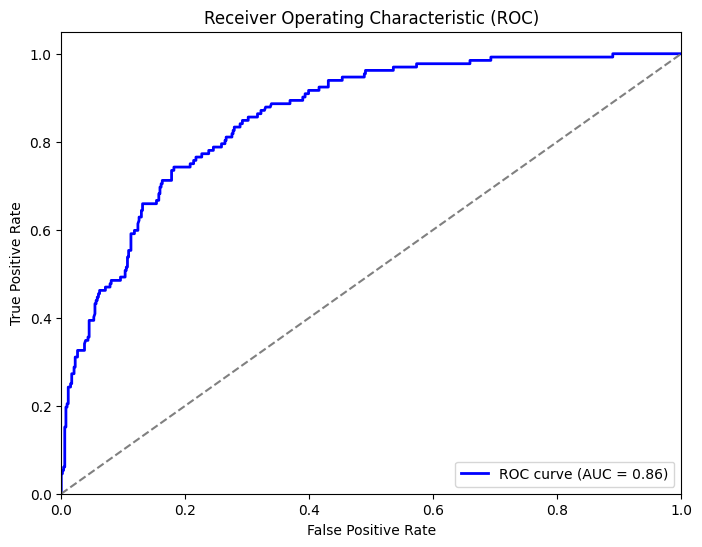

AUC: 0.86


In [558]:
y_probs = gradient_boosting.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_test, y_probs)
roc_auc = sklearn.metrics.auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line (no discrimination)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

print(f'AUC: {roc_auc:.2f}')

# Conclusion

In this notebook, I tried to first clean the Shark Attacks dataset. The dataset was small and very messy. For each column, I used different techniques for cleaning to avoid deleting too many rows, so we could keep more data after cleaning. Once the cleaning phase was done, I visualized the features using plots and applied some feature engineering to make the data better and more readable for machines. Next, I split the data into Train and Test datasets and tried to balance it using the SMOTE approach. Finally, I applied common machine learning methods for a classification task to build a model that can classify whether shark attacks were fatal or not. The results weren’t great because the data itself wasn’t clean or accurate. To get a better model in machine learning, the quality of the data is key. The next step for the future is to collect more real and accurate data on this topic and then apply all the methods mentioned in this notebook again. One interesting thing among all the models I tried is that the <b>Naive Bayes</b> method performed poorly compared to other machine learning models. This is because it’s a generative model, and it works best when features are independent and have a Gaussian-like shape. From our feature plots, we can see that most of them aren’t Gaussian-like and are skewed. Another reason, as already mentioned, could be the columns with lots of 'Others' values.